# Install Dependences

In [1]:
!pip install tensorflow==2.18.0
!pip install tensorflow-tpu==2.18.0 --find-links=https://storage.googleapis.com/libtpu-tf-releases/index.html
!git clone https://github.com/RR-project-group/TC-AcceleratedMonteCarloSimulation.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.4/615.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 84.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 75.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 118.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 115.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 126.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.2 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml_dtypes 0.5.1
    Uninstalling ml_dtypes-0.5.1:
      Successfully uninstalled ml_dtypes-0.5.1
Looking in links: https://storage.googleapis.com/libtpu-tf-releases/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.9

# Import library

In [2]:
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
import os
import pandas as pd
os.chdir('TC-AcceleratedMonteCarloSimulation')

/usr/local/lib/python3.11/dist-packages/jax/__init__.py:31: UserWarning: cloud_tpu_init failed: AttributeError("module 'libtpu' has no attribute 'get_library_path'")
 This a JAX bug; please report an issue at https://github.com/jax-ml/jax/issues
  _warn(f"cloud_tpu_init failed: {exc!r}\n This a JAX bug; please report "


# Detect ColabTPU

In [3]:
# ===== Detect TPU or fallback to CPU/GPU =====
try:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    tpu_strategy = tf.distribute.TPUStrategy(resolver)
    print("✅ TPU Detected.")
    tpu_available = True
except:
    tpu_strategy = tf.distribute.get_strategy()
    print("⚠️ TPU Not Found, running on CPU/GPU.")
    tpu_available = False

✅ TPU Detected.


# BS simulation

25


50


100

📊 Benchmark Results:
          label     dtype  n_steps     price    time
0   CPU-float32   float32       25  3.248831  10.339
1   CPU-float32   float32       50  3.244731  20.386
2   CPU-float32   float32      100  3.248410  40.715
3  TPU-bfloat16  bfloat16       25  3.265625   9.161
4  TPU-bfloat16  bfloat16       50  3.234375  18.274
5  TPU-bfloat16  bfloat16      100  3.203125  36.531


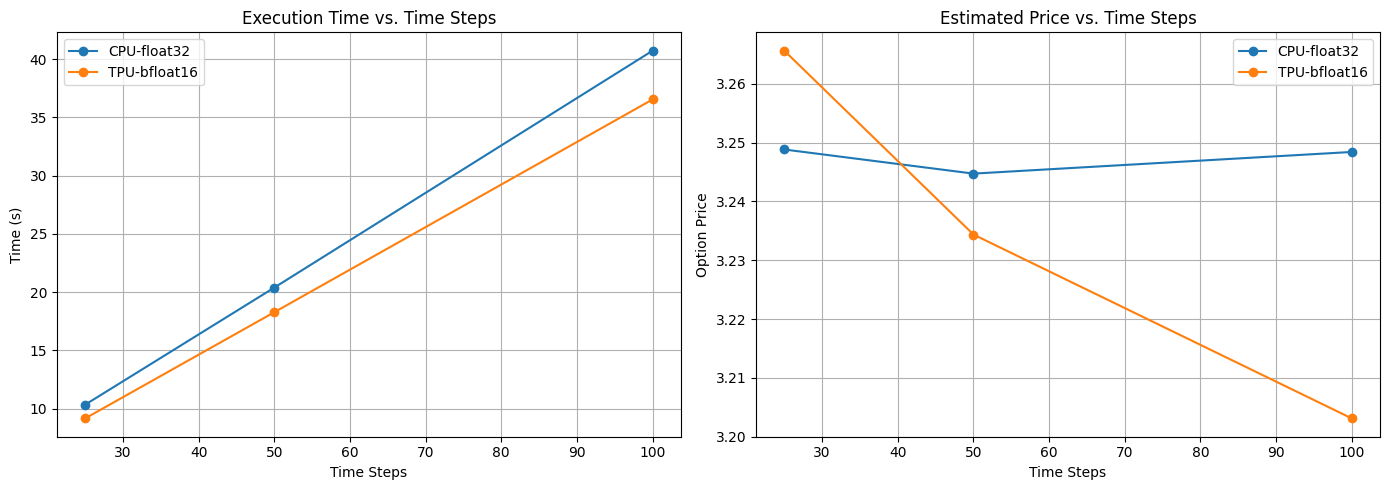

In [4]:
from bs import run_bs_simulation
import pandas as pd

# ===== Parameter Configuration =====
n_steps_list = [25, 50, 100]
n_paths = 10_000_000
dtype = tf.bfloat16
seed = (42, 42)

# ===== Run Experiment in Specific Strategy Context =====
def run_experiment(dtype, n_steps, label):
        start = time.time()
        price = run_bs_simulation(n_paths, n_steps, dtype=dtype, seed=seed)
        end = time.time()
        return {
            "label": label,
            "dtype": str(dtype.name),
            "n_steps": n_steps,
            "price": float(price.numpy()),
            "time": round(end - start, 3)
        }

# ===== Run all configurations =====
results = []

# CPU/GPU: float32 only
for n_steps in n_steps_list:
    result = run_experiment(tf.float32, n_steps, "CPU-float32")
    results.append(result)

# TPU tests: float32 and bfloat16


if tpu_available:
    for n_steps in n_steps_list:
        tf.keras.backend.clear_session()
        with tpu_strategy.scope():
            result = run_experiment(tf.bfloat16, n_steps, f"TPU-{dtype.name}")
        results.append(result)
        print(n_steps)

# ===== Display Results =====
df = pd.DataFrame(results)
print("\n📊 Benchmark Results:")
print(df)

# ===== Optional: Plotting =====
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Execution Time Plot
for key, grp in df.groupby('label'):
    ax[0].plot(grp['n_steps'], grp['time'], marker='o', label=key)
ax[0].set_title("Execution Time vs. Time Steps")
ax[0].set_xlabel("Time Steps")
ax[0].set_ylabel("Time (s)")
ax[0].legend()
ax[0].grid(True)

# Option Price Plot
for key, grp in df.groupby('label'):
    ax[1].plot(grp['n_steps'], grp['price'], marker='o', label=key)
ax[1].set_title("Estimated Price vs. Time Steps")
ax[1].set_xlabel("Time Steps")
ax[1].set_ylabel("Option Price")
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

# LMM simulation

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.



Running with 4000 paths...
CPU fp32 time: 0.5261s
TPU bfloat16 time: 0.4173s
MSE: 3.781598e-03

Running with 16000 paths...
CPU fp32 time: 0.5043s
TPU bfloat16 time: 0.5948s
MSE: 3.731045e-03

Running with 64000 paths...


CPU fp32 time: 1.1989s


TPU bfloat16 time: 1.2920s
MSE: 3.740543e-03

Running with 256000 paths...
CPU fp32 time: 3.5940s
TPU bfloat16 time: 3.9935s
MSE: 3.745191e-03


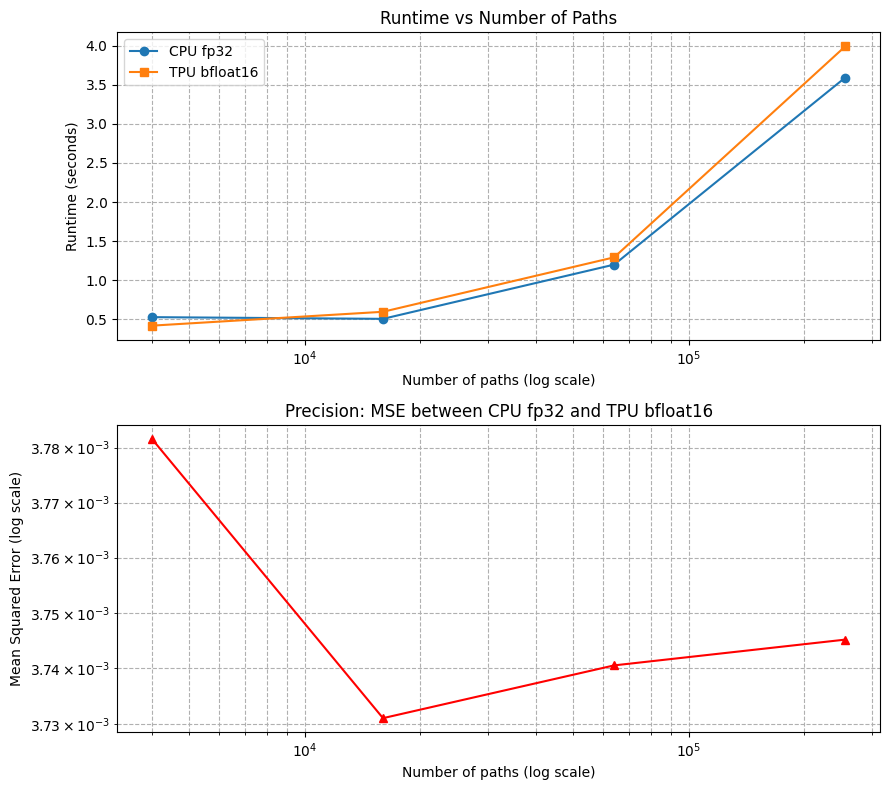

In [5]:
# Disable eager execution for performance
tf.config.experimental_run_functions_eagerly(False)

from lmm import generate_correlation_matrix, simulate_lmm_paths

N = 10
T = 50

corr_np = generate_correlation_matrix(N)
cov_np = corr_np

path_list = [4000, 16000, 64000, 256000]
cpu_times, tpu_times, mse_list = [], [], []

for p in path_list:
    print(f"\nRunning with {p} paths...")

    # CPU fp32
    with tf.device('/CPU:0'):
        start_cpu = time.time()
        res_fp32 = simulate_lmm_paths(tf.constant(cov_np, dtype=tf.float32), p, T, N, tf.float32)
        end_cpu = time.time()
        cpu_time = end_cpu - start_cpu
    print(f"CPU fp32 time: {cpu_time:.4f}s")

    cpu_times.append(cpu_time)

    # TPU bfloat16
    if tpu_strategy is not None:
        with tpu_strategy.scope():
            start_tpu = time.time()
            res_bf16 = simulate_lmm_paths(tf.constant(cov_np, dtype=tf.float32), p, T, N, tf.bfloat16)
            end_tpu = time.time()
            tpu_time = end_tpu - start_tpu
        print(f"TPU bfloat16 time: {tpu_time:.4f}s")
        tpu_times.append(tpu_time)

        diff = tf.reduce_mean(tf.square(tf.cast(res_fp32, tf.float32) - tf.cast(res_bf16, tf.float32)))
        mse = diff.numpy()
        print(f"MSE: {mse:.6e}")
        mse_list.append(mse)
    else:
        tpu_times.append(None)
        mse_list.append(None)

# Plot results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 8))

# Runtime plot
ax1.plot(path_list, cpu_times, 'o-', label='CPU fp32')
if tpu_strategy is not None:
    ax1.plot(path_list, tpu_times, 's-', label='TPU bfloat16')
ax1.set_xscale('log')
ax1.set_xlabel('Number of paths (log scale)')
ax1.set_ylabel('Runtime (seconds)')
ax1.set_title('Runtime vs Number of Paths')
ax1.legend()
ax1.grid(True, which="both", ls="--")

# MSE plot
if tpu_strategy is not None:
    ax2.plot(path_list, mse_list, 'r^-')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlabel('Number of paths (log scale)')
    ax2.set_ylabel('Mean Squared Error (log scale)')
    ax2.set_title('Precision: MSE between CPU fp32 and TPU bfloat16')
    ax2.grid(True, which="both", ls="--")

plt.tight_layout()
plt.show()